
# Q-learning 

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.


In [2]:
# In google collab, uncomment this:
# !wget https://bit.ly/2FMJP5K -q -O setup.py
# !bash setup.py 2>&1 1>stdout.log | tee stderr.log

# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%writefile qlearning.py
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        return max([self.get_qvalue(state, action) for action in possible_actions])

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        reference_qvalue = reward + gamma * self.get_value(next_state)
        updated_qvalue = learning_rate*reference_qvalue + (1 - learning_rate) * self.get_qvalue(state, action)

        self.set_qvalue(state, action, updated_qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action = max(possible_actions, key=lambda action: self.get_qvalue(state, action))

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        if random.random() < epsilon:
            return random.choice(possible_actions)
        else:
            return self.get_best_action(state)

Overwriting qlearning.py


#Try it on taxi

Here we use the qlearning agent on taxi env from openai gym. You will need to insert a few agent functions here.


In [4]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [5]:

from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [6]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update( s, 
                      a, 
                      r, 
                      next_s)
        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 0.2475 mean reward = -542.0


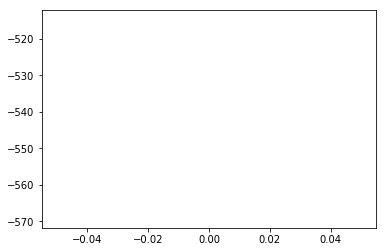

eps = 0.09059300446512424 mean reward = -74.2


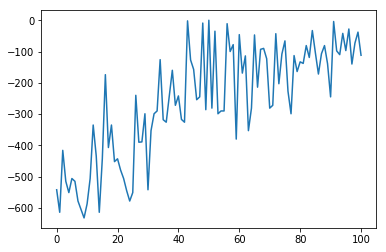

eps = 0.03315996952734553 mean reward = -24.8


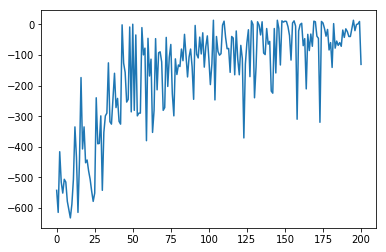

eps = 0.012137621282643224 mean reward = 0.5


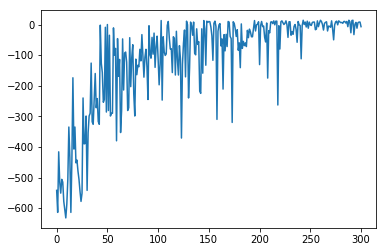

eps = 0.0044427619355736706 mean reward = 7.3


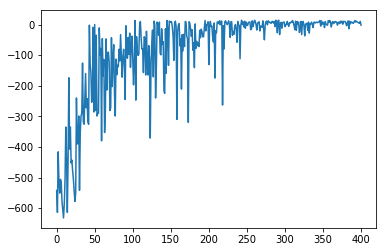

eps = 0.0016261945529976148 mean reward = 8.6


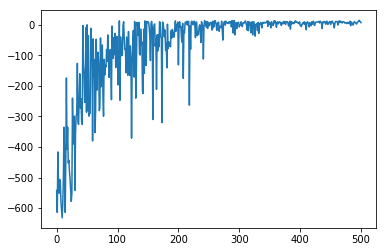

eps = 0.0005952397995994891 mean reward = 8.9


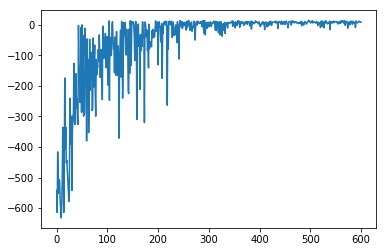

eps = 0.00021787701746640883 mean reward = 7.9


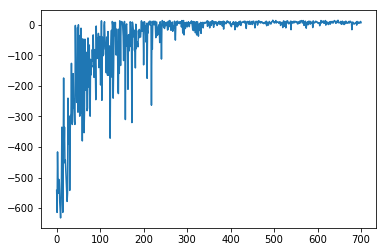

eps = 7.975003481285784e-05 mean reward = 7.8


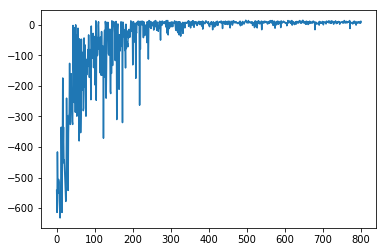

eps = 2.9191091959171894e-05 mean reward = 7.9


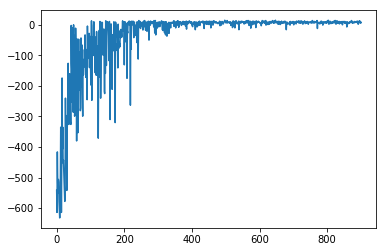

In [7]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

#Binarized state spaces
Use agent to train efficiently on CartPole-v0. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use 'round(x,n_digits)' (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to tuples of any kind of values.

first state:[ 0.0160333   0.02318753 -0.03280794 -0.03550831]


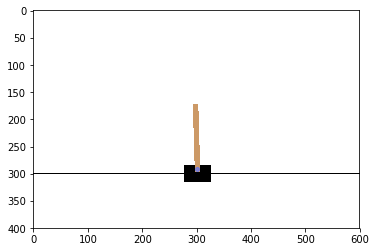

In [8]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))


#Play a few games¶

We need to estimate observation distributions. To do so, we'll play a few games and record all states.


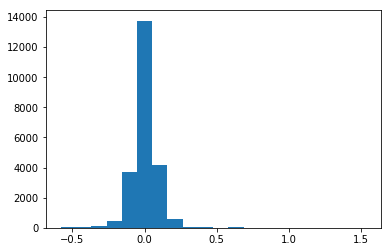

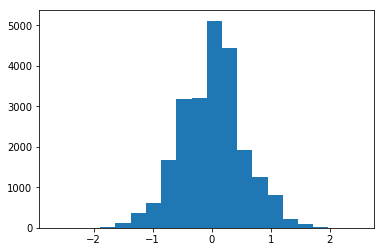

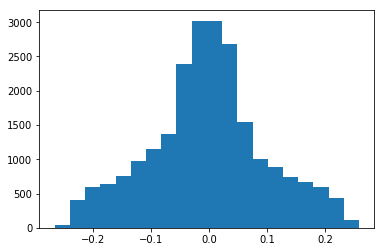

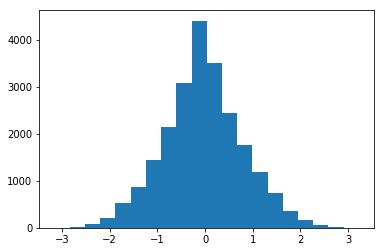

In [9]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()



In [10]:
def findPow(std_val):
    i = 0
    while std_val < 10:
        i+=1
        std_val*=10
    return i
#find  4*sigma interval and split find the first non-zero digit in it's spelling. now we will round
# all the values to it's size. ( if std*10 was  0.004  we will round to 4 digits)
round_pows = [findPow((np.std(all_states,0)*10)[i]) for i in range(4)]
print(round_pows)

[2, 1, 1, 1]


#Binarize environment

In [11]:
from gym.core import ObservationWrapper
from math import log10


class Binarizer(ObservationWrapper):

    def observation(self, state):

        for i in range(4):
            state[i] = round(state[i], round_pows[i])

        # hint: you can do that with round(x,n_digits)
        # you will need to pick a different n_digits for each dimension

        return tuple(state)



In [12]:
env = Binarizer(gym.make("CartPole-v0"))
print(env.reset())

(0.04, -0.0, -0.0, -0.0)


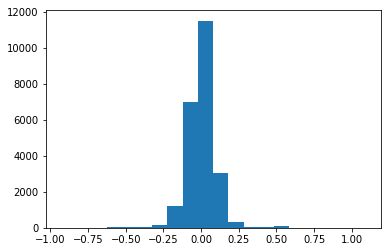

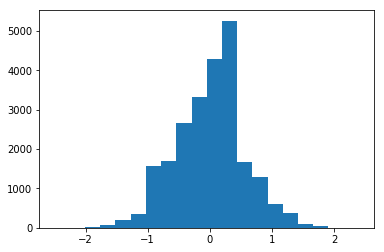

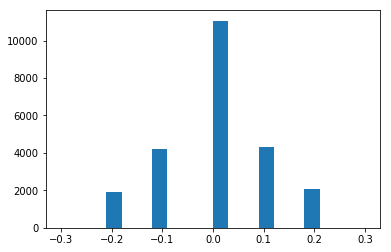

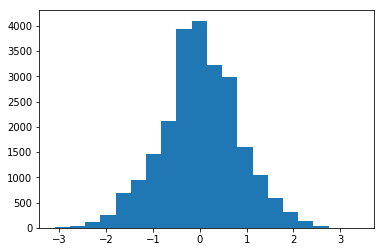

In [14]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()



#Learn binarized policy

Now let's train a policy that uses binarized state space.

##Tips:

* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization.
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (len(QLearningAgent._qvalues)), but not required.
* A reasonable agent should get to an average reward of >=50.



In [17]:


agent = QLearningAgent(alpha=0.1, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))



eps = 0.2499875 mean reward = 15.0


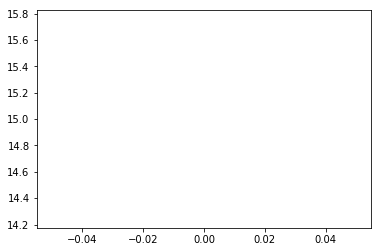

eps = 0.23779516850331833 mean reward = 17.0


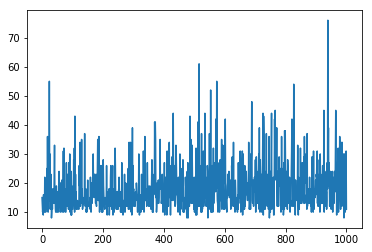

eps = 0.226197478528013 mean reward = 25.0


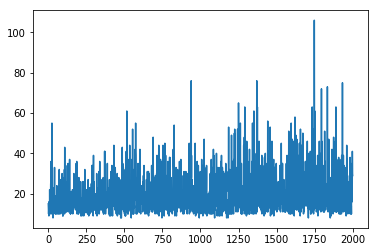

eps = 0.2151654283577963 mean reward = 21.2


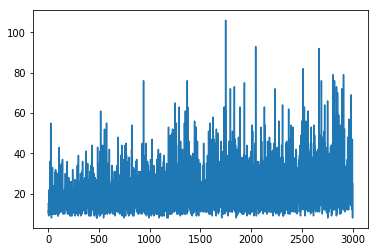

eps = 0.20467143074126057 mean reward = 39.3


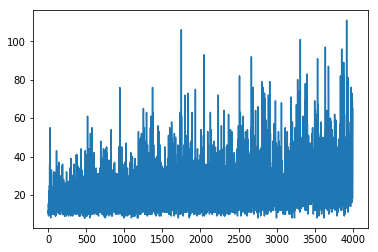

eps = 0.19468924390592834 mean reward = 29.6


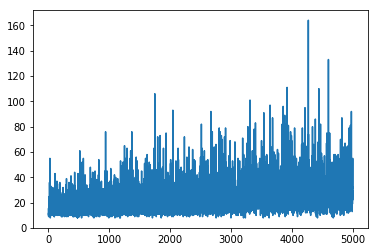

eps = 0.18519390593687232 mean reward = 25.6


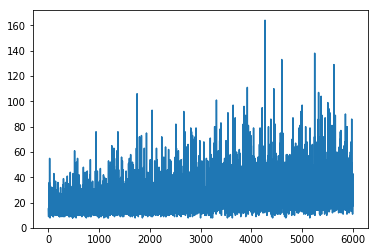

eps = 0.17616167235580318 mean reward = 27.7


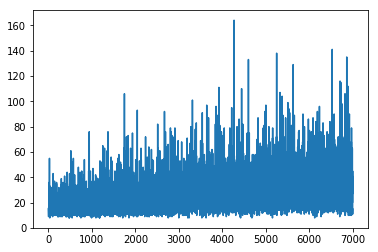

eps = 0.16756995674453573 mean reward = 40.2


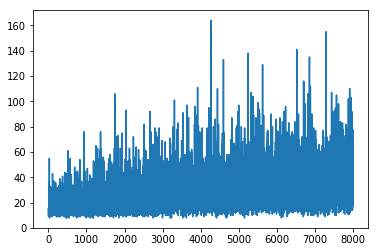

eps = 0.15939727426435527 mean reward = 53.2


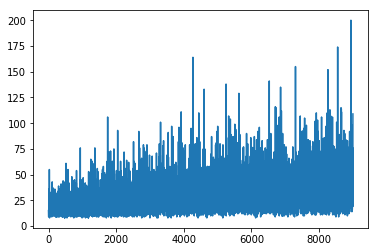

eps = 0.15162318793004448 mean reward = 36.8


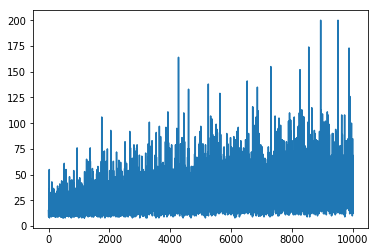

eps = 0.14422825750421633 mean reward = 41.2


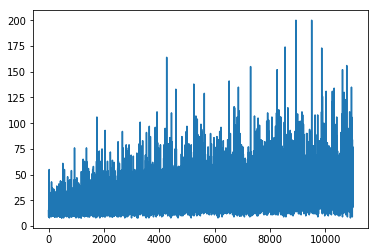

eps = 0.1371939908841648 mean reward = 36.0


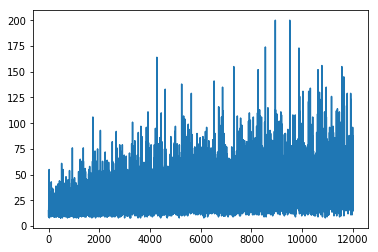

eps = 0.13050279785966415 mean reward = 46.5


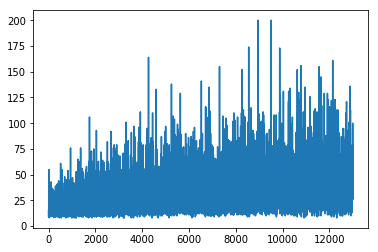

eps = 0.12413794612607928 mean reward = 52.8


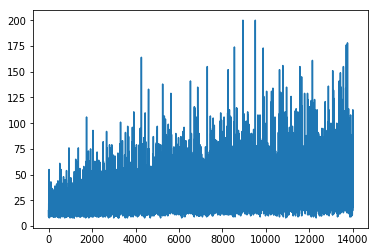

eps = 0.11808351944279999 mean reward = 39.9


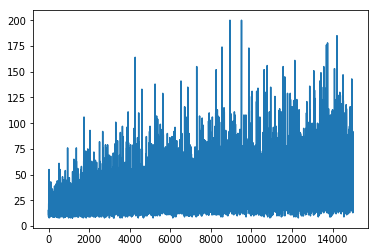

eps = 0.11232437783235376 mean reward = 38.3


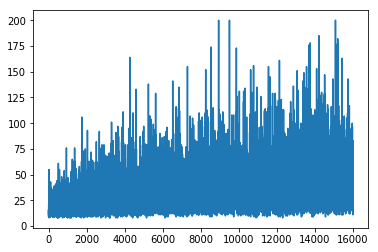

eps = 0.10684611972068578 mean reward = 42.7


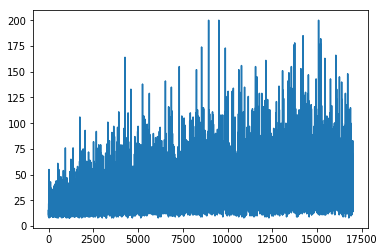

eps = 0.10163504592392109 mean reward = 56.0


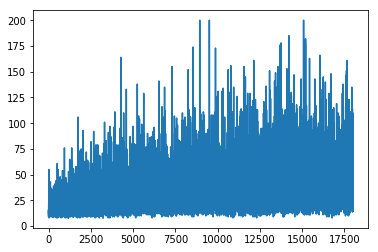

eps = 0.09667812539155506 mean reward = 44.8


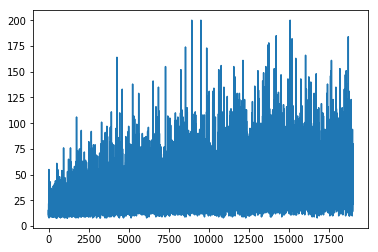

eps = 0.0919629626204105 mean reward = 42.7


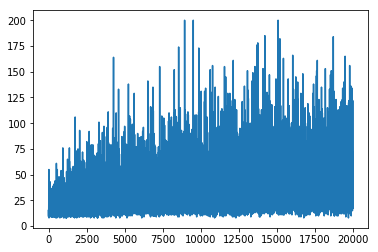

eps = 0.08747776665787246 mean reward = 43.3


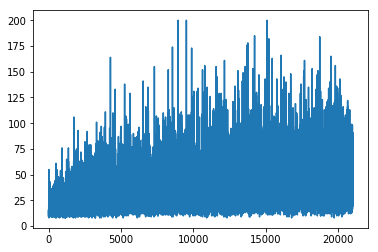

eps = 0.08321132161689175 mean reward = 55.0


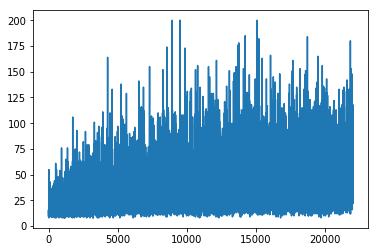

eps = 0.07915295862902198 mean reward = 45.2


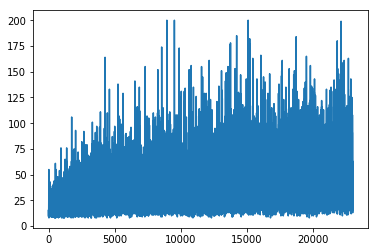

eps = 0.07529252916535643 mean reward = 40.7


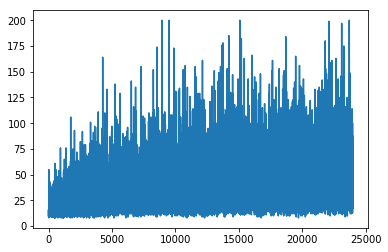

eps = 0.071620379658651 mean reward = 44.8


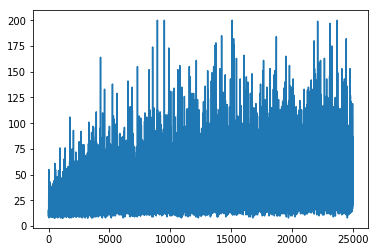

eps = 0.06812732736317043 mean reward = 66.2


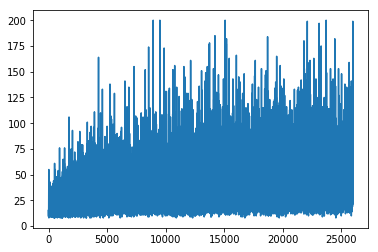

eps = 0.064804637391893 mean reward = 59.2


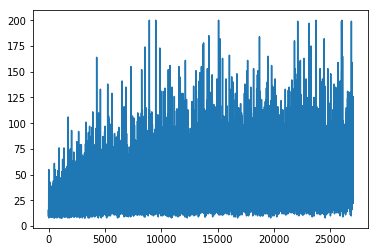

eps = 0.06164400087365025 mean reward = 56.9


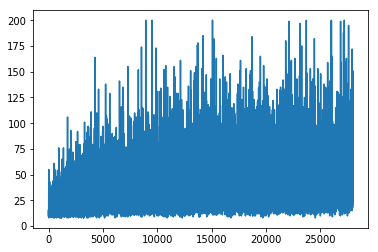

eps = 0.058637514175582335 mean reward = 67.3


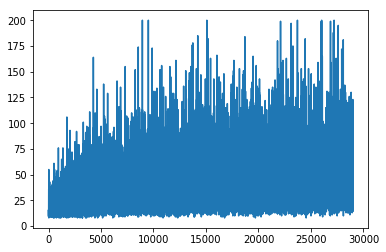

In [18]:

rewards = []
for i in range(30000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99995

    # OPTIONAL YOUR CODE: adjust epsilon
    if i % 1000 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()



In [19]:
len(agent._qvalues)

17513

In [29]:
from random import  randint
idxes = [randint(0, 5) for _ in range(4)]
print(idxes)
a = [('x1', 'y1'), ('x2', 'y2'), ('x3', 'y3'), ('x4', 'y4'),  ('x5', 'y5'),  ('x6', 'y6')]
print([a[i][0] for i in idxes])

[5, 0, 0, 5]
['x6', 'x1', 'x1', 'x6']
